# Setup

### Imports

In [1]:
import time
import os
from dataclasses import dataclass
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import scipy.spatial.distance
import transformers
from datasets import load_dataset

import lib.sst as sst
import lib.utils as utils

### Configuration

In [2]:
transformers.utils.logging.set_verbosity_error()
utils.fix_random_seeds()

cpu_device = 'cpu'
gpu_device = 'cuda' if torch.cuda.is_available() else 'cpu'

params = {'text.usetex': True,
          'text.latex.preamble': r"\usepackage{lmodern}",
          'font.size': 11,
          'font.family': 'lmodern',
          'figure.figsize': (10,10),
          'figure.dpi': 100,
          'savefig.dpi': 1000,
          }
plt.rcParams.update(params) 

### Load Datasets

In [3]:
dyna_r1 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r1.all")
dyna_r1_dev = dyna_r1['validation'].to_pandas()
# dyna_r1_test = dyna_r1['test'].to_pandas()
dyna_r2 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r2.all")
dyna_r2_train = dyna_r2['train'].to_pandas()
dyna_r2_dev = dyna_r2['validation'].to_pandas()
# dyna_r2_test = dyna_r2['test'].to_pandas()
print(f'dyna_r1_dev.shape: {dyna_r1_dev.shape}')
print(f'dyna_r2_dev.shape: {dyna_r2_dev.shape}')

DEV_DATAFRAMES = [dyna_r1_dev, dyna_r2_dev]
# TEST_DATAFRAMES = [dyna_r1_test, dyna_r2_test]

print(f'Dev dataset length:  {sum([len(df) for df in DEV_DATAFRAMES])}')
# print(f'Test dataset length: {sum([len(df) for df in TEST_DATAFRAMES])}')

Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r1.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 374.63it/s]
Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r2.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 499.54it/s]

dyna_r1_dev.shape: (3600, 12)
dyna_r2_dev.shape: (720, 12)
Dev dataset length:  4320


### Load Saved Experiments

In [4]:
# TODO warn if not found
experiment_file_names = [
    'experiment_RoBERTa-Base (Baseline).pt',
    'experiment_RoBERTa-Base (AAN).pt',
    'experiment_DynaSent-M1 (Baseline).pt',
    'experiment_DynaSent-M1 (AAN).pt',
]

colors = ['orangered', 'orangered', 'dodgerblue', 'dodgerblue']
linestyles = [(0, (5, 1)), 'solid'] * 2
hatches = ['//', None] * 2
    
experiments = []
for file_name, color, linestyle, hatch in zip(experiment_file_names, colors, linestyles, hatches):
    experiment = torch.load(os.path.join('models', file_name))
    # Force CPU to not run out of GPU memory with all models loaded
    experiment['model'].device = cpu_device
    experiment['model'].model.to(cpu_device)
    experiment['model'].model.eval()
    experiment['graph_color'] = color
    experiment['graph_linestyle'] = linestyle
    experiment['graph_hatch'] = hatch
    experiments.append(experiment)
    print(f'Loaded experiment for model {experiment["model"]}')

Loaded experiment for model RoBERTa-Base (Baseline)
Loaded experiment for model RoBERTa-Base (AAN)
Loaded experiment for model DynaSent-M1 (Baseline)
Loaded experiment for model DynaSent-M1 (AAN)


# 1. Quantitative Performance Evaluation

### Training Metrics

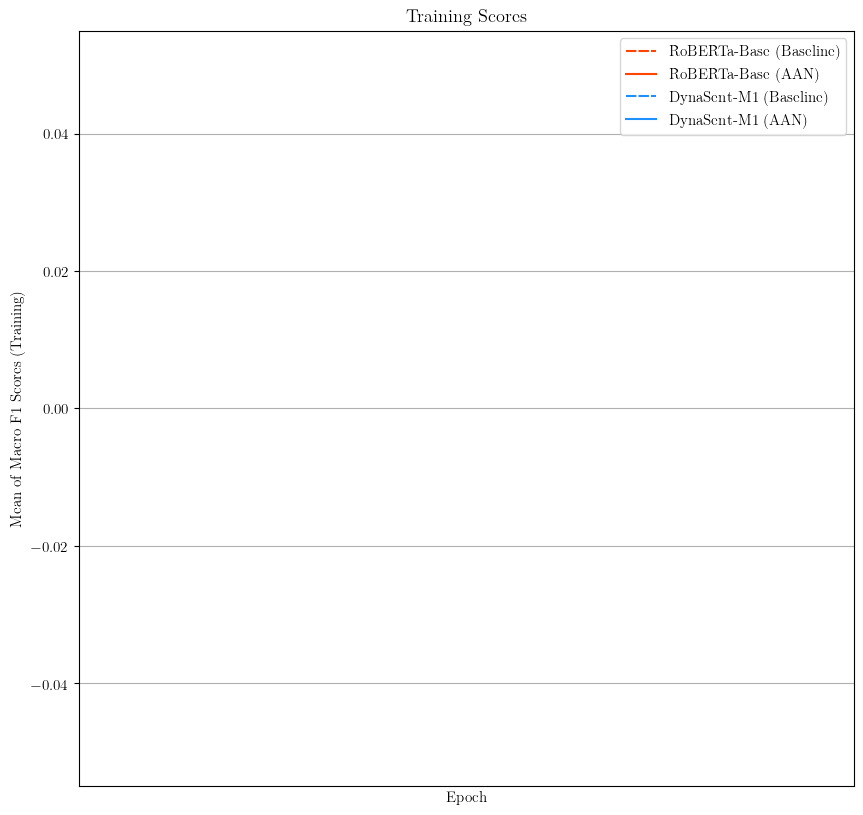

In [5]:
# Plot validation scores computed during training on held-out portions of the train set
for experiment, color, linestyle in zip(experiments, colors, linestyles):
    scores = experiment['model'].validation_scores
    epochs = list(range(1, len(scores) + 1))
    plt.plot(epochs, scores, label=f'{experiment["model"]}', color=color, linestyle=linestyle)
    # Data labels
    rounded_scores = [round(score, 3) for score in scores]
    for xy in zip(epochs, rounded_scores):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Mean of Macro F1 Scores (Training)')
plt.xlabel('Epoch')
plt.title('Training Scores')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Scores.png'))

plt.show()


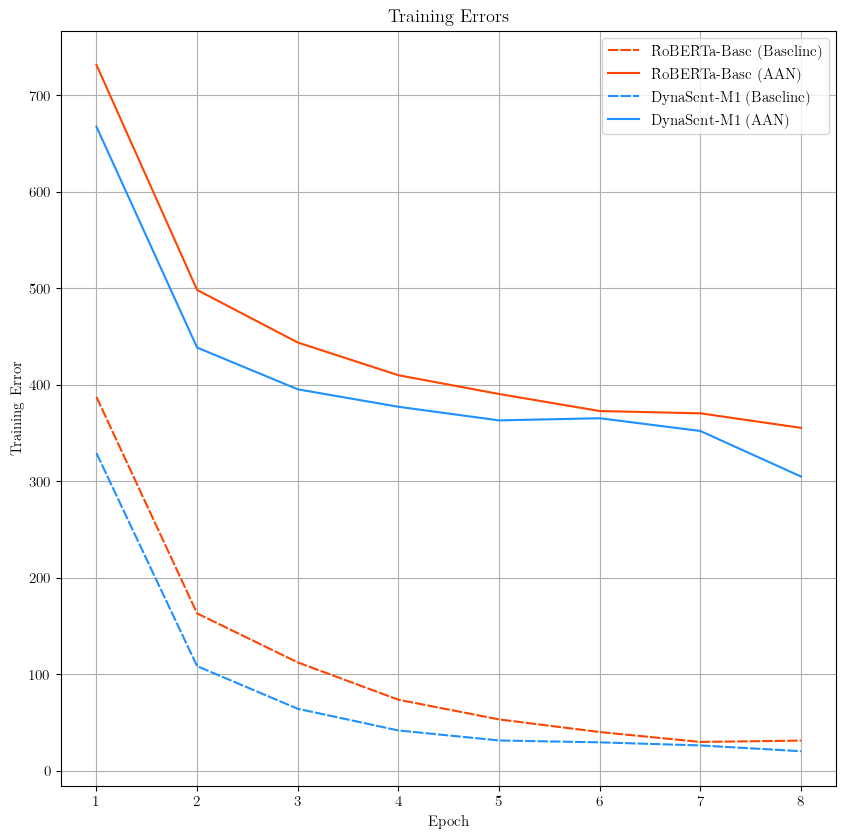

In [6]:
# Plot training losses
for experiment, color, linestyle in zip(experiments, colors, linestyles):
    errors = experiment['model'].training_errors
    epochs = list(range(1, len(errors) + 1))
    plt.plot(epochs, errors, label=f'{experiment["model"]}', color=color, linestyle=linestyle)
    # Data labels
    rounded_errors = [round(error, 3) for error in errors]
    for xy in zip(epochs, rounded_scores):
        plt.annotate('(%s)' % xy[1], xy=xy, textcoords='data')

plt.ylabel('Training Error')
plt.xlabel('Epoch')
plt.title('Training Errors')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join('plots', 'Training Errors.png'))

plt.show()


### Dev Set Evaluation

In [7]:
def evaluate_dataset(assess_df, title, score_func=utils.safe_macro_f1):
    # Build the dataset for assessment
    assess = sst.build_dataset(
        assess_df,
        experiments[0]['phi'],
        vectorize=False)

    # Run the model and assess the predictions
    scores = []
    all_preds = []
    for experiment in experiments:
        model = experiment['model']
        print(f'Evaluating {model}' , end =': ')
        
        # Move to GPU for faster processing
        model.device = gpu_device
        model.model.to(gpu_device)
        preds = model.predict(assess['X'])
        model.model.to(cpu_device)
        model.device = cpu_device
        
        score = score_func(assess['y'], preds)
        scores.append(score)
        all_preds.append(preds)
        print(score)

    for experiment, score in zip(experiments, scores):
        plt.bar(str(experiment['model']), score, color=experiment['graph_color'], hatch=experiment['graph_hatch'])
    plt.ylabel('Mean of Macro F1 Scores (Evaluation)')
    plt.xlabel('Model')
    plt.title(title)

    plt.savefig(os.path.join('plots', f'{title}.png'))

    return scores, all_preds, assess['y']
    

Evaluating RoBERTa-Base (Baseline): 0.6462503126993491
Evaluating RoBERTa-Base (AAN): 0.6716893455330585
Evaluating DynaSent-M1 (Baseline): 0.7325403610035933
Evaluating DynaSent-M1 (AAN): 0.7088449280505295


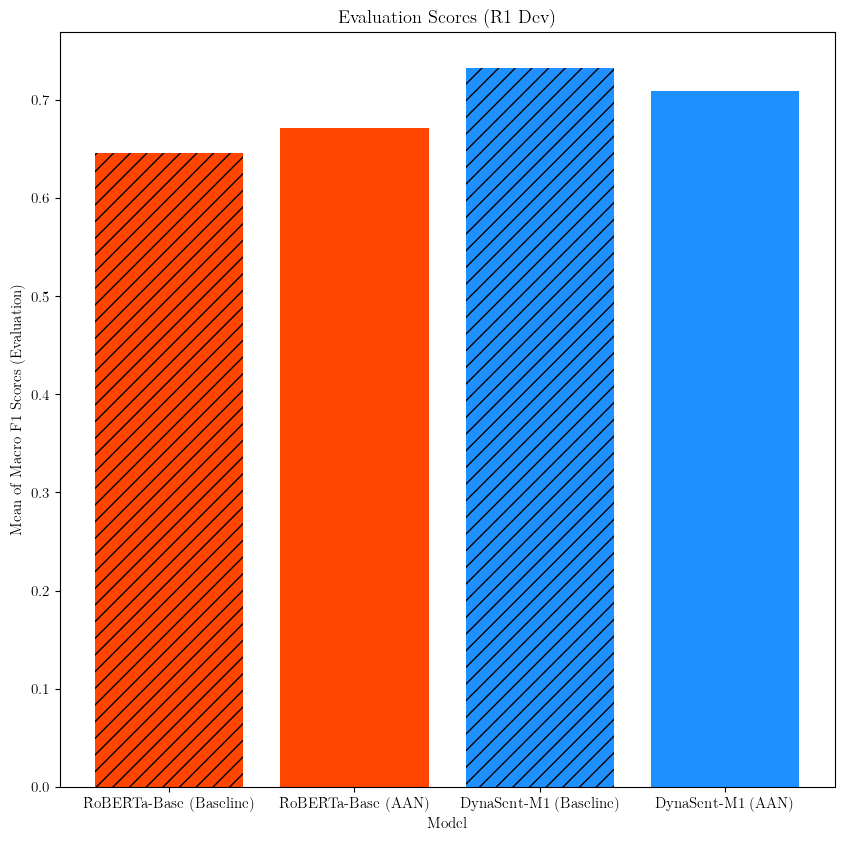

In [8]:
# Dynasent Round 1 Dev
dyna_r1_dev_scores, dyna_r1_dev_preds, dyna_r1_dev_gold = evaluate_dataset(dyna_r1_dev, 'Evaluation Scores (R1 Dev)')

Evaluating RoBERTa-Base (Baseline): 0.6817029173438455
Evaluating RoBERTa-Base (AAN): 0.6630101098439101
Evaluating DynaSent-M1 (Baseline): 0.6723721921688911
Evaluating DynaSent-M1 (AAN): 0.6584599006360895


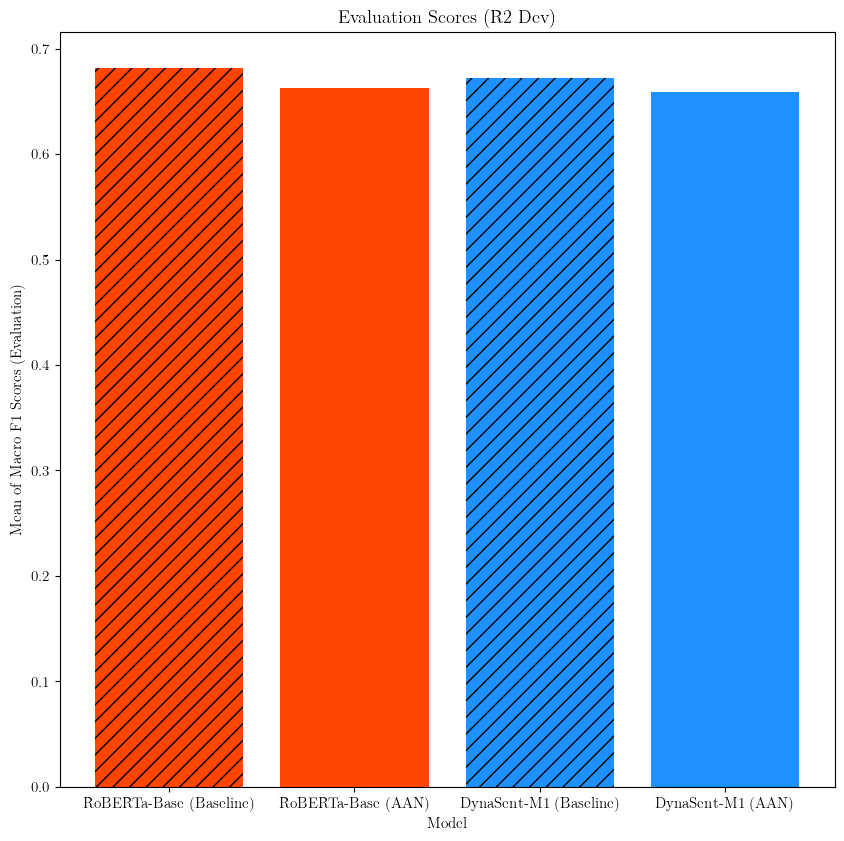

In [9]:
# Dynasent Round 2 Dev
dyna_r2_dev_scores, dyna_r2_dev_preds, dyna_r2_dev_gold = evaluate_dataset(dyna_r2_dev, 'Evaluation Scores (R2 Dev)')

### TODO Evaluate on test sets once at the end

In [10]:
# TODO Evaluate on test sets once at the end

### McNemar's Test of Statistical Significance

We can use [McNemar's Test](https://en.wikipedia.org/wiki/McNemar%27s_test) to evaluate whether the predictions of two different models on the same data set are statistically significant. If they aren't statistically significant (e.g. p > 0.01), then we can conclude that the models don't perform differently on that dataset.

In [11]:
# Use McNemar's Test to evaluate whether classifier outputs are significantly different
def calculate_significance(test_name, gold_labels, model_1_preds, model_2_preds):
    p_threshold = 0.01
    _, significance = utils.mcnemar(gold_labels, model_1_preds, model_2_preds)
    is_significant_text = 'NOT significant' if significance > p_threshold else 'SIGNIFICANT'
    print(f'p={significance:.3g} ({is_significant_text}) for test {test_name}')
    return significance

significance_tests = [
    ('Dyna R1 Dev: RoBERTa Baseline vs RoBERTa AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[0], dyna_r1_dev_preds[1]),
    ('Dyna R1 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[2], dyna_r1_dev_preds[3]),
    ('Dyna R1 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r1_dev_gold, dyna_r1_dev_preds[0], dyna_r1_dev_preds[2]),
    ('Dyna R1 Dev: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r1_dev_gold, dyna_r1_dev_preds[1], dyna_r1_dev_preds[3]),
    # TODO add line break
    ('Dyna R2 Dev: RoBERTa Baseline vs RoBERTa AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[0], dyna_r2_dev_preds[1]),
    ('Dyna R2 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[2], dyna_r2_dev_preds[3]),
    ('Dyna R2 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline', dyna_r2_dev_gold, dyna_r2_dev_preds[0], dyna_r2_dev_preds[2]),
    ('Dyna R2 Dev: RoBERTa AAN vs DynaSent-M1 AAN', dyna_r2_dev_gold, dyna_r2_dev_preds[1], dyna_r2_dev_preds[3]),
    # TODO Add Dyna Test set significance
]

for test_name, gold_labels, model_1_preds, model_2_preds in significance_tests:
    calculate_significance(test_name, gold_labels, model_1_preds, model_2_preds)

p=0.0129 (NOT significant) for test Dyna R1 Dev: RoBERTa Baseline vs RoBERTa AAN
p=0.00181 (SIGNIFICANT) for test Dyna R1 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=2.12e-27 (SIGNIFICANT) for test Dyna R1 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline
p=7.58e-07 (SIGNIFICANT) for test Dyna R1 Dev: RoBERTa AAN vs DynaSent-M1 AAN
p=0.416 (NOT significant) for test Dyna R2 Dev: RoBERTa Baseline vs RoBERTa AAN
p=0.582 (NOT significant) for test Dyna R2 Dev: DynaSent-M1 Baseline vs DynaSent-M1 AAN
p=0.628 (NOT significant) for test Dyna R2 Dev: RoBERTa Baseline vs DynaSent-M1 Baseline
p=0.803 (NOT significant) for test Dyna R2 Dev: RoBERTa AAN vs DynaSent-M1 AAN


# Concept-Based Explanations

Our AAN-based models are able to produce concept-based explanations of their classification decisions.

We choose to run all of our explanations on the DynaSent Model 1 AAN model, but these could also be evaluated on the RoBERTA-Base AAN model or other AAN models.

### Precomputation

In [12]:
# Use the DynaSent Model 1 AAN
desired_model_name = 'DynaSent-M1 (AAN)' # 'RoBERTa-Base (AAN)'
concept_explanation_model = [experiment['model'] for experiment in experiments if str(experiment['model']) == desired_model_name][0]
_ = concept_explanation_model.model.to(gpu_device)

In [13]:
# Choose a dictionary of keywords to use as inputs

# Import a small (25k) English dictionary
# https://github.com/dolph/dictionary
with open('data/popular.txt') as word_file:
    concept_keyword_list = np.array(word_file.read().split())

# Debug choose only a random 1000
# concept_keyword_list = concept_keyword_list[np.random.choice(len(concept_keyword_list), size=1000, replace=False)]

# Alternative: Use RoBERTa's tokens (50k tokens)
# tokenizer = concept_explanation_model.roberta_tokenizer
# concept_keyword_list: list[str] = list(tokenizer.vocab.keys())

num_concept_keywords = len(concept_keyword_list)
print(f'Loaded {num_concept_keywords} keywords. Examples:')
print(concept_keyword_list[np.random.choice(num_concept_keywords, size=6, replace=False)])

Loaded 25322 keywords. Examples:
['cram' 'legislature' 'untoward' 'waves' 'hurray' 'decked']


In [14]:
# Precompute (or load) the abstraction-attention context representations (10x768) for each keyword.
# We will compare these representations to find keywords associated with concepts.
from lib.sentiment_models import NUM_CONCEPTS, HIDDEN_DIM, BATCH_SIZE

FORCE_COMPUTE_REPRESENTATIONS = False

keywords_representations_save_path = os.path.join('data', 'keywords_representations.npy')
must_precompute_representations = not os.path.exists(keywords_representations_save_path) or FORCE_COMPUTE_REPRESENTATIONS
if not must_precompute_representations:
    print(f'Loading representations for {num_concept_keywords} keywords...')
    keywords_representations = np.load(keywords_representations_save_path)
    print(f'Loaded representations for {len(keywords_representations)} keywords.')

    if len(keywords_representations) != num_concept_keywords:
        print(f'Whoops! Loaded {len(keywords_representations)} keyword representations, but was expecting {num_concept_keywords}. Regenerating them now.')
        must_precompute_representations = True

if must_precompute_representations:
    print(f'Precomputing representations for {num_concept_keywords} keywords...')

    keywords_representations = np.zeros((num_concept_keywords, NUM_CONCEPTS, HIDDEN_DIM))

    num_batches = (num_concept_keywords / BATCH_SIZE) + 1

    start_time = time.time()
    for batch_i in range(0, num_concept_keywords, BATCH_SIZE):
        # Forward the input through the model so it stores the attention contexts
        batch_inputs = concept_keyword_list[batch_i:batch_i+BATCH_SIZE].tolist()
        concept_explanation_model.predict(batch_inputs)

        fraction_complete = (batch_i + 1) / num_concept_keywords
        minutes_since_start = (time.time() - start_time) / 60
        minutes_expected = minutes_since_start / fraction_complete * (1 - fraction_complete)
        message = f'Keyword {batch_i + 1}/{num_concept_keywords} ' \
            f'({round(fraction_complete * 100, 2)}%). ' \
            f'{round(minutes_since_start, 2)} min elapsed, {round(minutes_expected, 2)} min remaining. '
        utils.progress_bar(message)

        # Capture the saved attention contexts
        ctx_abs = concept_explanation_model.pooling_module.ctx_abs
        keywords_representations[
            batch_i:min(batch_i + BATCH_SIZE, num_concept_keywords), :, :] = ctx_abs

    np.save(keywords_representations_save_path, keywords_representations)

Loading representations for 25322 keywords...
Loaded representations for 1000 keywords.
Whoops! Loaded 1000 keyword representations, but was expecting 25322. Regenerating them now.
Precomputing representations for 25322 keywords...


### Explanation Generation

In [20]:
@dataclass
class ConceptExplanation:
    """Represents an explanation of a single sentence and facilitates easy printing."""
    sentence: str # The input sentence
    prediction: str # The sentiment prediction
    scores: list[float] # The scores for each of the K concepts
    keywords: list[list[str]] # The keywords for each of the K concepts

    def get_explanation_string(self, sort_by_scores=True):
        table_string = f'{"ID":^5}{"Score":^9}{"Keywords":<20}\n'
        table_string += '='*50 + '\n'
        # TODO implement sorting by scores
        for id, (score, keyword_list) in enumerate(zip(self.scores, self.keywords)):
            table_string += f'{id:^5}{score:.5f}  {", ".join(keyword_list):<20}\n'
        return f'Prediction: {str.upper(self.prediction)}\nSentence: "{self.sentence}"\n{table_string}'

    def __repr__(self):
        return self.get_explanation_string()


def get_concept_explanation(sentence, num_keywords_per_concept=6):
    """Gets the scores and keywords for the K=10 concepts for a given input sentence."""
    # Forward the input through the model
    prediction = concept_explanation_model.predict([sentence])[0]

    # TODO DEBUG will remove
    # dataset = concept_explanation_model.build_dataset([sentence], ['negative'])
    # dataloader = concept_explanation_model._build_dataloader(dataset)
    # for batch_num, batch in enumerate(dataloader, start=1):
    #     batch = [x.to(concept_explanation_model.device, non_blocking=True) for x in batch]

    #     X_batch = batch[: -1]
    #     y_batch = batch[-1]

    #     batch_preds = concept_explanation_model.model(*X_batch)

    #     err = concept_explanation_model.loss(batch_preds, y_batch) 
    # concept_explanation_model.model.to(gpu_device)
    # concept_explanation_model.loss.to(gpu_device)
    # concept_explanation_model.loss(prediction, prediction)

    # Capture the saved attention weights
    ctx_abs = concept_explanation_model.pooling_module.ctx_abs
    attn_agg = concept_explanation_model.pooling_module.attn_agg

    # Get the scores from the aggregation-attention weights
    scores = attn_agg.cpu().squeeze().numpy().tolist()

    # Compute the cosine similarity between this sentence's abs-attention context representations
    # and the precomputed keyword representations (each are of size NUM_CONCEPTS x HIDDEN_DIM).
    similarities = np.zeros((num_concept_keywords, NUM_CONCEPTS))
    for keyword_i in range(num_concept_keywords):
        for concept_i in range(NUM_CONCEPTS):
            sentence_repr = ctx_abs[:, concept_i, :].squeeze().cpu().numpy()
            keyword_repr = keywords_representations[keyword_i, concept_i, :]
            similarities[keyword_i, concept_i] = scipy.spatial.distance.cosine(sentence_repr, keyword_repr)

    # Choose to top n most similar keywords to represent each concept
    keywords = [[]]*NUM_CONCEPTS
    for concept_i in range(NUM_CONCEPTS):
        indices = similarities[:, concept_i].argsort()[-num_keywords_per_concept:][::-1]
        keywords[concept_i] = concept_keyword_list[indices]
        # TODO if slow, use argpartition + argsort
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

    # Wrap it all up in a cozy object
    return ConceptExplanation(sentence, prediction, scores, keywords)

In [21]:
# Test the explanations with some hand-written example sentences
print(get_concept_explanation('Why did the food taste so bad?'))

Prediction: NEGATIVE
Sentence: "Why did the food taste so bad?"
 ID    Score  Keywords            
  0  0.00148  nourishment, explicit, complicate, implicate, excommunicated, berating
  1  0.03015  explicit, perished, implicate, highness, jiggling, indicated
  2  0.00152  maim, nourishment, throbbing, discriminating, lightness, dashing
  3  0.16963  includes, potion, al, recognize, compilation, implicate
  4  0.15142  definition, includes, the, viewed, ed, every
  5  0.18531  complicate, implicate, communicated, communicate, excommunicated, consulate
  6  0.00774  complicate, submissive, explicit, erect, indicated, flinging
  7  0.22193  complicate, implicate, communicate, signifying, recognise, recognize
  8  0.00148  wiggled, proudest, drooling, vindictiveness, vanishes, teensy
  9  0.22934  complicate, implicate, communicated, communicate, consulate, signifying



In [22]:
print(get_concept_explanation('The car is unsafe and Peoria Ford just says it not us it\'s Ford.'))

Prediction: NEGATIVE
Sentence: "The car is unsafe and Peoria Ford just says it not us it's Ford."
 ID    Score  Keywords            
  0  0.00094  nourishment, berating, boggling, helplessness, controversy, humbling
  1  0.11369  potion, it, maxwell, description, the, al
  2  0.00097  nourishment, maim, throbbing, lightness, discriminating, dashing
  3  0.14420  includes, potion, al, the, it, is
  4  0.13674  definition, includes, the, ed, viewed, every
  5  0.18573  communicate, complicate, implicate, signifying, recognise, visualize
  6  0.02582  highness, complicate, implicate, jiggling, explicit, flinging
  7  0.20001  testimony, communicate, recognize, recognise, complicate, understand
  8  0.00093  wiggled, drooling, proudest, vindictiveness, vanishes, teensy
  9  0.19098  testimony, communicate, recognize, sponsoring, visualize, recognise



In [23]:
print(get_concept_explanation('My doctor was a woman.'))

Prediction: NEUTRAL
Sentence: "My doctor was a woman."
 ID    Score  Keywords            
  0  0.00026  nourishment, berating, boggling, controversy, devastation, baffling
  1  0.03090  yet, is, at, morrow, difference, ar
  2  0.00026  maim, nourishment, throbbing, dashing, lightness, servicing
  3  0.03800  abundantly, remarkably, admirably, absolutes, seamless, amazingly
  4  0.02343  definition, every, excepted, the, viewed, ed
  5  0.29311  fattening, frustrates, splendid, absolutes, browbeating, antagonizing
  6  0.13940  splendid, extraordinary, fattening, overjoyed, fantabulous, absolutes
  7  0.16895  splendid, antagonizing, fattening, absolutes, feckless, fantabulous
  8  0.01815  felicity, perished, explicit, complicate, facetious, semiautomatic
  9  0.28754  frustrates, absolutes, fattening, splendid, indescribable, incriminating



## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'phi': the feature function used
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_datasets': list of datasets, each with the same structure as the value of 'train_dataset'
'predictions': list of lists of predictions on the assessment datasets
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the each of the assessment dataasets
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [24]:
def find_errors(experiment):
    """Find mistaken predictions.

    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.

    Returns
    -------
    pd.DataFrame

    """
    dfs = []
    for i, dataset in enumerate(experiment['assess_datasets']):
        df = pd.DataFrame({
            'raw_examples': dataset['raw_examples'],
            'predicted': experiment['predictions'][i],
            'gold': dataset['y']})
        df['correct'] = df['predicted'] == df['gold']
        df['dataset'] = i
        dfs.append(df)
    return pd.concat(dfs)

In [25]:
rnn_analysis = find_errors(rnn_experiment)

NameError: name 'rnn_experiment' is not defined

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [ ]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [ ]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])
    &
    (analysis['gold'] == 'positive')
]

error_group.shape[0]

for ex in error_group['raw_examples'].sample(5, random_state=1):
    print("="*70)
    print(ex)

In [ ]:
def predict_one_rnn(text):
    # List of tokenized examples:
    X = [rnn_experiment['phi'](text)]
    # Standard `predict` step on a list of lists of str:
    # TODO be sure to change the model to eval mode before predicting
    preds = rnn_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]

# Explaining Errors

We can use our concept-based explanations to transparently discover errors and biases in the model.

In [ ]:
# TODO try to do this with both examples that the model gets wrong and some hand-written biased sentences to reveal biases in the model.